# Distance Plot
Notebook that generates a box-and-whisker plot for a given dataset.

### Configure Paths
In `MARIAM/data/` each folder is a *dataset*. Each dataset consists of a subfolder of trials for each controller type:
- `<MM-DD>_p_experiments/`: Data from position controller trials.
- `<MM-DD>_a_experiments/`: Data from admittance controller trials.
- `<MM-DD>_dp_experiments/`: Data from dynamic parameterization controller trials. 

Each trial folder consists of the following files:
- `monica_admittance_data.csv`: Admittance and manipulator data for Monica.
- `ross_admittance_data.csv`: Admittance and manipulator data for Ross.
- `trajectory_data.csv`: Locations and orientations of the payload, Monica, and Ross.

In [153]:
# Dataset path
dataset_path = '../../data/08-30_dataset/'

# Controller type paths
dp_experiments_path = dataset_path + '08-30_dp_experiments/'
a_experiments_path = dataset_path + '08-30_a_experiments/'
p_experiments_path = dataset_path + '08-30_p_experiments/'

### Create Data Structure
All csv data across all trials will be organized in a singular data structure with the following format:
```python
data = {
    'p': {  # position controller
        'trial_01': {
            'trajectory': DataFrame,
            'monica_admittance': DataFrame, 
            'ross_admittance': DataFrame
        },
        'trial_02': { ... },
        ...
    },
    'a': { ... },  # admittance controller  
    'dp': { ... }  # dynamic parameterization controller
}
```

In [154]:
import pandas as pd
import os
import re
from pathlib import Path

def load_experiment_data(dataset_path):
    """
    Load all robotic experiment data without preprocessing.
    
    Args:
        dataset_path: Path to the main dataset folder (e.g., '../../data/08-30_dataset/')
    
    Returns:
        dict: Nested dictionary with structure data[controller][trial_num][file_type]
    """
    
    data = {}
    date_prefix = Path(dataset_path).name.split('_')[0]
    
    # File naming conventions by controller type
    file_mappings = {
        'p': {'monica': 'monica_position_data.csv', 'ross': 'ross_position_data.csv'},
        'a': {'monica': 'monica_admittance_data.csv', 'ross': 'ross_admittance_data.csv'},
        'dp': {'monica': 'monica_admittance_data.csv', 'ross': 'ross_admittance_data.csv'}
    }
    
    for controller in ['p', 'a', 'dp']:
        controller_path = os.path.join(dataset_path, f"{date_prefix}_{controller}_experiments")
        
        if not os.path.exists(controller_path):
            print(f"Warning: Path {controller_path} does not exist.")
            continue
            
        print(f"Loading {controller} controller data...")
        data[controller] = {}
        
        # Process all trial folders
        trial_folders = [f for f in os.listdir(controller_path) 
                        if os.path.isdir(os.path.join(controller_path, f)) and 'trial' in f]
        
        for trial_folder in sorted(trial_folders):
            trial_match = re.search(r'trial_(\d+)', trial_folder)
            if not trial_match:
                continue
                
            trial_num = trial_match.group(1)
            trial_path = os.path.join(controller_path, trial_folder)
            
            # Load trajectory data
            trajectory_file = os.path.join(trial_path, 'trajectory_data.csv')
            if not os.path.exists(trajectory_file):
                print(f"  Warning: trajectory_data.csv not found in trial {trial_num}")
                continue
            
            try:
                data[controller][trial_num] = {
                    'trajectory': pd.read_csv(trajectory_file)
                }
                
                # Load monica and ross data files
                for robot, filename in file_mappings[controller].items():
                    file_path = os.path.join(trial_path, filename)
                    if os.path.exists(file_path):
                        try:
                            data[controller][trial_num][f"{robot}_{controller}"] = pd.read_csv(file_path)
                        except Exception as e:
                            print(f"    Error loading {filename} in trial {trial_num}: {e}")
                    else:
                        print(f"    Warning: {filename} not found in trial {trial_num}")
                
            except Exception as e:
                print(f"  Error loading trial {trial_num}: {e}")
    
    # Summary
    print("\n" + "="*40)
    print("LOADING SUMMARY")
    print("="*40)
    total_trials = 0
    for controller in data:
        trial_count = len(data[controller])
        total_trials += trial_count
        print(f"{controller.upper()}: {trial_count} trials")
    print(f"Total: {total_trials} trials")
    
    return data
    

data = load_experiment_data(dataset_path=dataset_path)

Loading p controller data...
    Error loading ross_position_data.csv in trial 07: No columns to parse from file
    Error loading ross_position_data.csv in trial 20: No columns to parse from file
    Error loading ross_position_data.csv in trial 22: No columns to parse from file
Loading a controller data...
    Error loading ross_admittance_data.csv in trial 24: No columns to parse from file
Loading dp controller data...

LOADING SUMMARY
P: 20 trials
A: 20 trials
DP: 26 trials
Total: 66 trials


### Data Pre-Processing
Each The monica and ross CSV files for each trial will be cropped to the start and end times of the `trajectory_data.csv` file.

In [155]:
def crop_experiment_data(data):
    """
    Crop all non-trajectory data to match trajectory time bounds.
    
    Args:
        data: Data structure from load_experiment_data()
    
    Returns:
        dict: Same structure with cropped data
    """
    
    cropped_data = {}
    
    for controller in data:
        print(f"Cropping {controller} controller data...")
        cropped_data[controller] = {}
        
        for trial_num in data[controller]:
            trial_data = data[controller][trial_num]
            
            # Get time bounds from trajectory data
            trajectory_df = trial_data['trajectory']
            start_time = trajectory_df['ros_time_ns'].min()
            end_time = trajectory_df['ros_time_ns'].max()
            
            # Initialize with trajectory data (no cropping needed)
            cropped_data[controller][trial_num] = {
                'trajectory': trajectory_df.copy()
            }
            
            # Crop all other data files
            for data_type, df in trial_data.items():
                if data_type == 'trajectory':
                    continue
                    
                if 'ros_time_ns' not in df.columns:
                    print(f"    Warning: ros_time_ns column not found in {data_type}, trial {trial_num}")
                    cropped_data[controller][trial_num][data_type] = df.copy()
                    continue
                
                # Crop to trajectory time range
                original_length = len(df)
                cropped_df = df[(df['ros_time_ns'] >= start_time) & (df['ros_time_ns'] <= end_time)].copy()
                
                # Check coverage and warn if incomplete
                df_start, df_end = df['ros_time_ns'].min(), df['ros_time_ns'].max()
                if df_start > start_time or df_end < end_time:
                    print(f"    Warning: {data_type} trial {trial_num} doesn't fully cover trajectory time range")
                
                # print(f"    {data_type} trial {trial_num}: {original_length} -> {len(cropped_df)} rows")
                cropped_data[controller][trial_num][data_type] = cropped_df
    
    print("\nCropping complete!")
    return cropped_data

processed_data = crop_experiment_data(data=data)

Cropping p controller data...
Cropping a controller data...
Cropping dp controller data...

Cropping complete!


### Calculate Distance Travelled
The *distance traveled* is the distance the payload traveled before it was dropped. The time the payload is dropped is signaled by force value dropping below 0.5 for both robots. The total distance is calculated by summing the Euclidian distance from one time step to the next for each time step.

In [156]:
import numpy as np

def calculate_distance_traveled(data):
    """
    Calculate distance traveled by payload for each trial before force drops below 0.5.
    
    Args:
        data: Data structure from load_experiment_data() or crop_experiment_data()
    
    Returns:
        dict: {controller: [distances]} where distances is list of distances for each trial
    """
    
    distance_results = {}
    
    for controller in data:
        print(f"Processing {controller} controller...")
        distances = []
        
        for trial_num in sorted(data[controller].keys()):
            trial_data = data[controller][trial_num]
            
            try:
                # Get data
                trajectory_df = trial_data['trajectory']
                monica_df = trial_data[f'monica_{controller}']
                ross_df = trial_data[f'ross_{controller}']
                
                # Find earliest time force < 0.5 for each robot
                monica_low_mask = monica_df['force'] < 0.5
                if monica_low_mask.any():
                    monica_low_force_time = monica_df[monica_low_mask]['ros_time_ns'].min()
                else:
                    monica_low_force_time = monica_df['ros_time_ns'].max()
                
                ross_low_mask = ross_df['force'] < 0.01
                if ross_low_mask.any():
                    ross_low_force_time = ross_df[ross_low_mask]['ros_time_ns'].min()
                else:
                    ross_low_force_time = ross_df['ros_time_ns'].max()
                
                # Take the larger timestamp
                low_force_time = max(monica_low_force_time, ross_low_force_time)
                
                # Filter trajectory data up to low_force_time
                filtered_trajectory = trajectory_df[trajectory_df['ros_time_ns'] <= low_force_time]
                
                # Calculate total distance
                payload_distances = np.sqrt(
                    np.diff(filtered_trajectory['act_payload_x'])**2 + 
                    np.diff(filtered_trajectory['act_payload_y'])**2
                )
                total_distance = np.sum(payload_distances)
                
                distances.append(total_distance)
                # print(f"  Trial {trial_num}: {total_distance:.3f}")
                
            except Exception as e:
                print(f"  Error in trial {trial_num}: {e}")
        
        distance_results[controller] = distances
    
    return distance_results

distance_results = calculate_distance_traveled(data=processed_data)

# Print all distances
print("Distances traveled for debugging:")
for controller, distances in distance_results.items():
    for distance in distances:
        print(f"  {controller} controller distance: {distance:.3f}")

Processing p controller...
  Error in trial 07: 'ross_p'
  Error in trial 17: 'force'
  Error in trial 20: 'ross_p'
  Error in trial 22: 'ross_p'
  Error in trial 24: 'force'
Processing a controller...
  Error in trial 24: 'ross_a'
Processing dp controller...
Distances traveled for debugging:
  p controller distance: 0.079
  p controller distance: 0.042
  p controller distance: 0.089
  p controller distance: 0.033
  p controller distance: 0.135
  p controller distance: 0.141
  p controller distance: 0.076
  p controller distance: 0.133
  p controller distance: 0.091
  p controller distance: 0.155
  p controller distance: 0.163
  p controller distance: 0.139
  p controller distance: 0.211
  p controller distance: 0.208
  p controller distance: 0.205
  a controller distance: 1.716
  a controller distance: 0.148
  a controller distance: 0.161
  a controller distance: 0.153
  a controller distance: 0.208
  a controller distance: 1.705
  a controller distance: 0.162
  a controller distance:

## Plots
This section uses data gathered previously to make the following plots:
- Distance Traveled (box plot)

### Distance Traveled

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Box plot statistics:
Position:
  Mean: 0.13
  Median: 0.13
  Std Dev: 0.06
Admittance:
  Mean: 0.64
  Median: 0.21
  Std Dev: 0.78
Dynamic Param:
  Mean: 1.80
  Median: 2.18
  Std Dev: 0.66


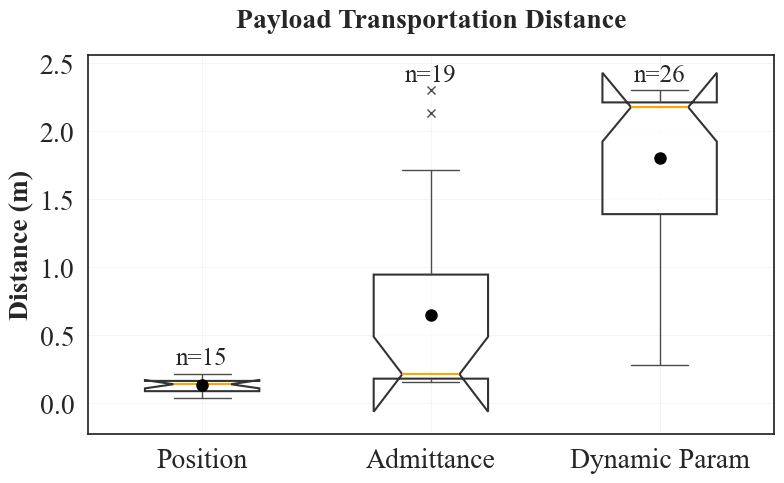

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_distance_box_plot(distance_results, fig_size=(18, 6), fontsize=16):
    """
    Create a notched box and whisker plot from distance_results.
    
    Args:
        distance_results: Dictionary from calculate_distance_traveled() 
                         {controller: [distances]}
        fig_size: Figure size tuple
        fontsize: Font size for labels and text
    """
    
    # Convert distance_results to DataFrame for seaborn
    plot_data = []
    controller_labels = {
        'p': 'Position',
        'a': 'Admittance', 
        'dp': 'Dynamic Param'
    }
    
    for controller, distances in distance_results.items():
        for distance in distances:
            plot_data.append({
                'experiment_type': controller_labels.get(controller, controller),
                'distance_traveled': distance
            })
    
    distance_df = pd.DataFrame(plot_data)
    
    # Create the plot
    plt.figure(figsize=fig_size)
    sns.set_theme(
        style='white',
        font="Times New Roman"
    )
    
    ax = sns.boxplot(
        data=distance_df, 
        x="experiment_type", 
        y="distance_traveled",
        width=0.5,
        notch=True,
        showcaps=True,
        showmeans=True,
        flierprops={"marker": "x"},
        medianprops={
            "color": "orange",
            "linewidth": 1.5
        },
        boxprops={
            "facecolor": "white",
            "edgecolor": "black",
            "linewidth": 1.5,
            "alpha": 0.8
        },
        meanprops={
            "marker": "o",
            "markerfacecolor": "black",
            "markeredgecolor": "black",
            "markersize": 8
        },
    )

    plt.title("Payload Transportation Distance",
              fontsize=fontsize, fontweight='bold', pad=20)
    plt.xlabel("", fontsize=fontsize, fontweight='semibold')
    plt.ylabel("Distance (m)", fontsize=fontsize, fontweight='semibold')
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Add sample size annotations above each box
    for i, controller_type in enumerate(distance_df['experiment_type'].unique()):
        subset = distance_df[distance_df['experiment_type'] == controller_type]
        n = len(subset)
        
        # Get the maximum y-value for this box (top of upper whisker or outliers)
        box_data = subset['distance_traveled'].values
        q3 = np.percentile(box_data, 75)
        q1 = np.percentile(box_data, 25)
        iqr = q3 - q1
        upper_whisker = box_data.max()
        
        # Place text slightly above the upper whisker
        y_min, y_max = ax.get_ylim()
        plt.ylim(y_min - 0.05, y_max * 1.02)  # Add 10% padding to the top
        ax.text(i, upper_whisker + (y_max - y_min) * 0.01, f'n={n}', 
               ha='center', va='bottom', fontsize=fontsize-2, fontweight='normal')
        
    # Save as png and eps
    plt.savefig("./figures/distance_box_plot.png", dpi=300)
    plt.savefig("./figures/distance_box_plot.eps")

    # Print box plot statistics
    print("Box plot statistics:")
    for controller_type in distance_df['experiment_type'].unique():
        subset = distance_df[distance_df['experiment_type'] == controller_type]
        print(f"{controller_type}:")
        print(f"  Mean: {subset['distance_traveled'].mean():.2f}")
        print(f"  Median: {subset['distance_traveled'].median():.2f}")
        print(f"  Std Dev: {subset['distance_traveled'].std():.2f}")

    plt.tight_layout()
    plt.show()


create_distance_box_plot(distance_results=distance_results, fig_size=(8, 5), fontsize=20)